In [1]:
import numpy as np
import os
import pickle
import astropy
import corner
import matplotlib.pyplot as plt
import emcee
from math import isinf

from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import selections
from enterprise.signals import gp_signals
from enterprise.signals import gp_priors
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals.utils import hd_orf
from enterprise.signals import utils
from enterprise_extensions.deterministic import cw_block_circ

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

from ent_data_simulation import params_injected

import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

Optional mpi4py package is not installed.  MPI support is not available.


## Load pulsars and PTA object

In [2]:
# load Enterprise pulsar objects
with open('ent_data_simulation/data/enterprise_pulsars.pkl', 'rb') as f:
    psrs = pickle.load(f)

# load Enterprise PTA object
with open('ent_data_simulation/data/pta.pkl', 'rb') as f:
    pta = pickle.load(f)

for psr in psrs:
    print(psr.name)

J1312+0051


In [3]:
print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J1312+0051_linear_timing_model           TimingModel                    0                   

params:
__________________________________________________________________________________________
J1312+0051_measurement_noise             MeasurementNoise               0                   

params:
__________________________________________________________________________________________
J1312+0051_red_noise                     FourierBasisGP                 2                   

params:
J1312+0051_red_noise_log10_A:Uniform(pmin=-18.0, pmax=-11.0)                              
J1312+0051_red_noise_gamma:Uniform(pmin=1.0, pmax=7.0)                                    
__________________________________________________________________________________________
Total params: 2
Varying params: 2
Common params: 0
Fixed params: 0
Number of pulsars: 1



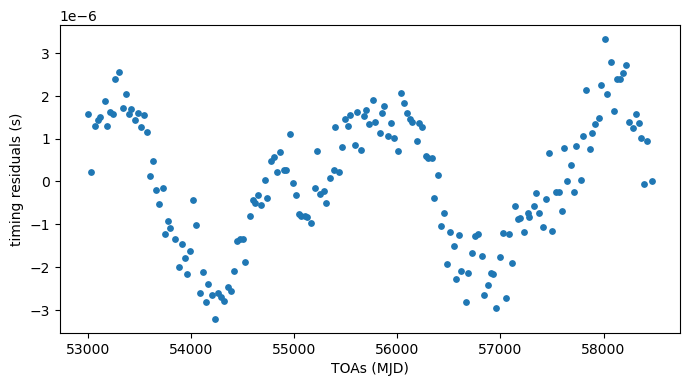

In [4]:
# plot timing residuals
psr_ndx = 0
plt.figure(figsize=(8, 4))
plt.scatter(psrs[psr_ndx].toas / 86400., psrs[psr_ndx].residuals, s=15)
plt.xlabel('TOAs (MJD)')
plt.ylabel('timing residuals (s)')
plt.show()

## test Enterprise likelihood

In [5]:
[print(name) for name in pta.param_names];

J1312+0051_red_noise_gamma
J1312+0051_red_noise_log10_A


In [6]:
x_mins = np.array([0., -20.])
x_maxs = np.array([7., -10.])
x_inj = np.array([params_injected.RN_gammas_inj[0],
                  params_injected.RN_logamps_inj[0]
                  ])
x_inj

array([  3.6, -13.2])

In [7]:
# # store injected parameters and bounds on parameter space

# x_inj = []
# x_mins = []
# x_maxs = []
# for i in range(len(wrapped_psrs)):
#     x_inj.append(ent_psrs[i].pdist[0])
#     x_mins.append(0.1)
#     x_maxs.append(7.0)
#     x_inj.append(np.random.uniform(0, np.pi))
#     x_mins.append(0.0)
#     x_maxs.append(2. * np.pi)
#     x_inj.append(4.33)
#     x_mins.append(gamma_min)
#     x_maxs.append(gamma_max)
#     x_inj.append(-14.0)
#     x_mins.append(logamp_min)
#     x_maxs.append(logamp_max)
#     x_inj.append(0.0)
#     x_mins.append(-1.0)
#     x_maxs.append(1.0)
#     x_inj.append(0.0)
#     x_mins.append(-1.0)
#     x_maxs.append(1.0)
#     x_inj.append(9.0)
#     x_mins.append(7.)
#     x_maxs.append(10.0)
#     x_inj.append(1.0)
#     x_mins.append(-1.)
#     x_maxs.append(2.)
#     x_inj.append(-8.0)
#     x_mins.append(-10.)
#     x_maxs.append(-7.)
#     x_inj.append(0.0)
#     x_mins.append(-np.pi / 2.)
#     x_maxs.append(np.pi / 2.)
#     x_inj.append(np.pi)
#     x_mins.append(0.)
#     x_maxs.append(2. * np.pi)
#     x_inj.append(0.0)
#     x_mins.append(-np.pi / 2.)
#     x_maxs.append(np.pi / 2.)
#     x_inj.append(4.33)
#     x_mins.append(gamma_min)
#     x_maxs.append(gamma_max)
#     x_inj.append(-14.0)
#     x_mins.append(logamp_min)
#     x_maxs.append(logamp_max)
# x_inj = np.array(x_inj)
# x_mins = np.array(x_mins)
# x_maxs = np.array(x_maxs)

In [8]:
def get_dict(params):
    return {param_name: param for param_name, param in zip(pta.param_names, params)}

In [9]:
# uniform prior
def uniform_lnprior(params):
    if np.logical_or(np.any(params < x_mins),
                     np.any(params > x_maxs)):
        return -np.inf
    else:
        return 0.

# likelihood function
def get_lnlike(params):
    return pta.get_lnlikelihood(get_dict(params))

# posterior
def get_lnpost(params):
    return uniform_lnprior(params) + get_lnlike(params)

In [10]:
# # psr_dists_inj, psr_dist_stdev = np.load('data_simulation/data/psr_dists.npy')
# def ln_prior_CW(psr_dists):
#     return -np.sum(np.array([(dist - dist_inj)**2. / (2. * stdev**2.) 
#                     for dist, dist_inj, stdev in zip(psr_dists, pta_dict['psr_dists'], np.ones(len(wrapped_psr)) * 0.2)]))

In [11]:
# num_psrs = len(pta.pulsars)
# def ln_prior(params):
#     psr_dists = params[:4 * num_psrs][::4]
#     return ln_prior_CW(psr_dists)

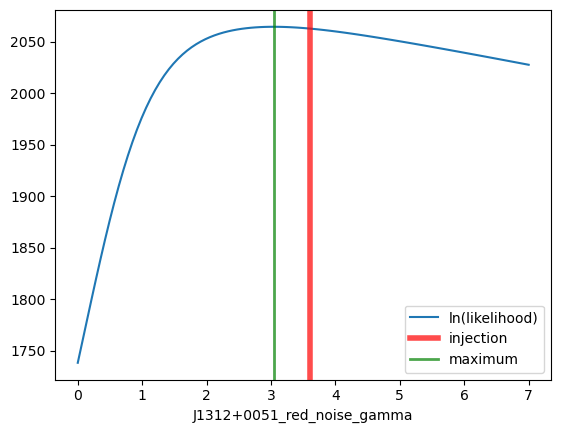

In [12]:
# plot cross section of the likelihood over one parameter
# other parameters fixed at injected values

param_index = 0
num_pts = 100
param_vals = np.linspace(x_mins[param_index], x_maxs[param_index], num_pts)
likelihood_vals = np.zeros(num_pts)
for i in range(num_pts):
    params = np.copy(x_inj)
    params[param_index] = param_vals[i]
    likelihood_vals[i] = get_lnpost(params)


plt.plot(param_vals, likelihood_vals, color='C0', label='ln(likelihood)')
plt.axvline(x_inj[param_index], color='red', alpha=0.7, label='injection', lw=4)
plt.axvline(param_vals[np.argmax(likelihood_vals)], color='green', alpha=0.7, label='maximum', lw=2)
plt.xlabel(pta.param_names[param_index])
plt.legend()
plt.show()

In [13]:
pta.get_phi(get_dict(x_inj))[0].shape

(48,)

## MCMC

In [14]:
# set initial parameters drawn from prior
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

# set up the sampler:
# initial jump covariance matrix
cov = np.eye(ndim)
outDir = 'enterprise_chains'

# sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov, 
#                  outDir=outDir, resume=False)
sampler = ptmcmc(ndim, get_lnlike, uniform_lnprior, cov, 
                 outDir=outDir, resume=False)

# sampler for N steps
N = int(1e5)  # normally, we would use 5e6 samples (this will save time)
# x0 = np.hstack([p.sample() for p in pta.params])
x0 = x_inj
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

# store chains in compressed binary format
print('Loading chains.')
chains = np.loadtxt('enterprise_chains/chain_1.txt', skiprows=int(0), usecols=(range(ndim + 1)))
np.save('enterprise_chains/chains.npy', chains)
if os.path.exists('enterprise_chains/chains.npy') and os.path.getsize('enterprise_chains/chains.npy') > 0:
    os.remove('enterprise_chains/chain_1.txt')
    print('Chain saved to .npy file.')
    print('Original .txt file deleted successfully.')
else:
    print('Error: .npy file not created correctly. Original .txt file was not deleted.')

Finished 10.00 percent in 1.437097 s Acceptance rate = 0.51647Adding DE jump with weight 50
Finished 100.00 percent in 12.369504 s Acceptance rate = 0.51081
Run Complete
Loading chains.
Chain saved to .npy file.
Original .txt file deleted successfully.


## post-processing

In [15]:
# load chain samples
chains = np.load('enterprise_chains/chains.npy')
samples = chains[:,:-1]

# number of samples
num_samples = len(samples)

# load likelihood values
lnposts = chains[:,-1]

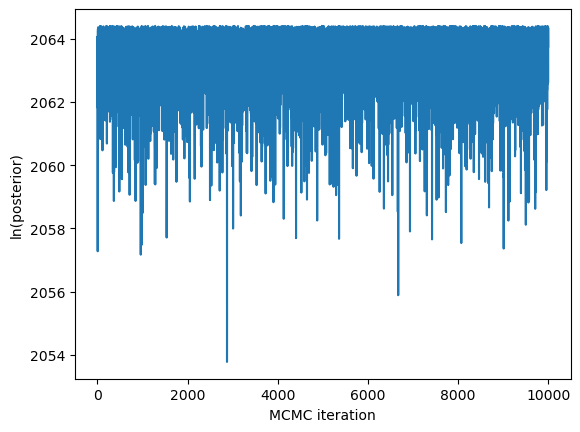

In [16]:
# plot likelihood of samples

plt.plot(lnposts)
plt.xlabel('MCMC iteration')
plt.ylabel('ln(posterior)')
plt.show()

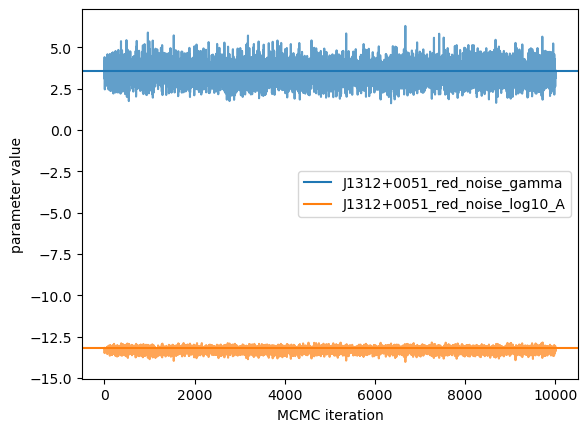

In [17]:
# make trace plot for parameters
for i in range(2):
    plt.plot(samples[:,i], color=f'C{i}', alpha=0.7)
    plt.axhline(x_inj[i], color=f'C{i}', label=pta.param_names[i])

plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend()
plt.show()

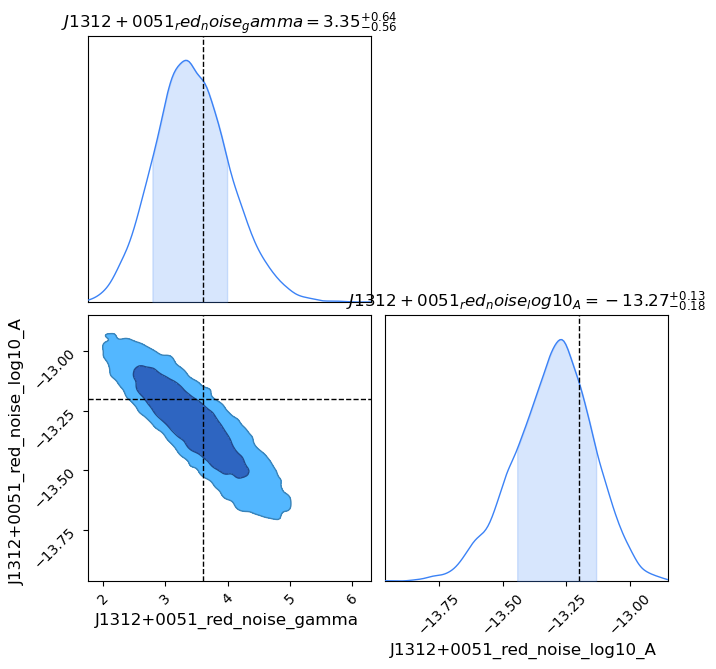

In [18]:
# make corner plot
ent_df = pd.DataFrame(samples, columns=pta.param_names)
c = ChainConsumer()
c.add_chain(Chain(samples=ent_df, name='Enterprise'))
c.add_truth(Truth(location=get_dict(x_inj)))
fig = c.plotter.plot()